In [3]:
#import some python libraries
import csv, glob, os, sys, numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import timeit
from scipy.optimize import curve_fit
from scipy import optimize
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy import signal
from numpy import NaN, Inf, arange, isscalar, asarray, array
import numpy.polynomial.polynomial as poly
import timeit

plt.rcParams['xtick.labelsize'] = 15; plt.rcParams['ytick.labelsize'] = 15 #make size of axis tick labels larger

# IMPORT FREQUENCY DOMAIMN DATA FILE #################################################################
ffile = 'C:\\Users\\a6q\\Desktop\\CorrEL noise measurements\\2017-07-14 s-swcnt 7c noise h2o.txt' #frequency filename
rawfdata = pd.read_table(ffile, skiprows=2399, header=0, error_bad_lines=False, sep='\s+') #read in file
#####################################################################################################
floatdata = rawfdata.apply(pd.to_numeric, errors='coerce') #change from string to float, coercing to NaN 
fdata  = floatdata.dropna()

print(fdata)

        Frequency/Hz  volt.noise/V  curr.noise/A   pow.noise/W
0              0.000      0.002790  3.260000e-08  9.080000e-11
1              0.005      0.002790  3.260000e-08  9.080000e-11
2              0.010      0.000209  1.710000e-10  3.570000e-14
3              0.015      0.000176  7.520000e-11  1.320000e-14
4              0.020      0.000244  9.660000e-11  2.350000e-14
5              0.025      0.000053  1.570000e-12  8.350000e-17
6              0.030      0.000285  8.930000e-11  2.550000e-14
7              0.035      0.000227  5.580000e-11  1.270000e-14
8              0.040      0.000115  1.850000e-10  2.130000e-14
9              0.045      0.000176  1.390000e-10  2.450000e-14
10             0.050      0.000192  9.430000e-11  1.810000e-14
11             0.055      0.000036  2.680000e-11  9.740000e-16
12             0.060      0.000094  4.510000e-11  4.230000e-15
13             0.065      0.000290  1.060000e-10  3.090000e-14
14             0.070      0.000558  1.040000e-10  5.790

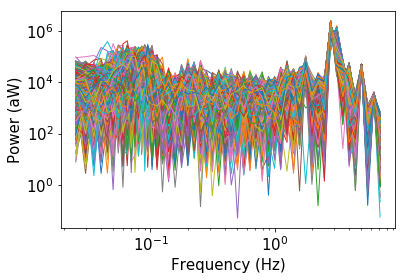

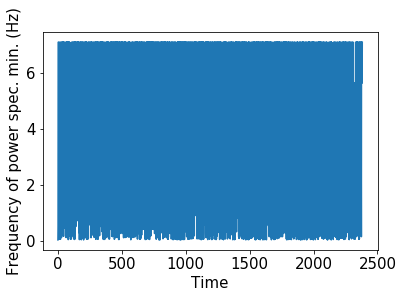

In [10]:
#convert columns into numpy arrays:
allf = np.array(fdata['Frequency/Hz']) #frequency in Hz
allv = np.array(fdata['volt.noise/V'])*1e6 #voltage in microVolts
alli = np.array(fdata['curr.noise/A'])*1e9 #current in nanoAmps
allp = np.array(fdata['pow.noise/W'])*1e18 #power in attoWatts

fsweep = []; i=0
while allf[i+1] > allf[i]: fsweep.append(allf[i]); i=i+1 #find length of each freq sweep

#reshape into matrices to separate each individual frequency sweep
fmat0 = np.reshape(allf, (-1,len(fsweep)+1)); imat0 = np.reshape(alli, (-1,len(fsweep)+1))
vmat0 = np.reshape(allv, (-1,len(fsweep)+1)); pmat0 = np.reshape(allp, (-1,len(fsweep)+1))

#set starting/ending indices to remove first 1 or 2 errant points from 0 Hz freq. measurements###################
si = 5 ; ei = 3
########################################################################################################
#new empty matrices without first/last couple points
fmat = np.ones((np.shape(fmat0)[0],np.shape(fmat0)[1]-si-ei));
vmat=np.copy(fmat); imat=np.copy(fmat); pmat=np.copy(fmat); zmat=np.copy(fmat)

for i in range(len(fmat)): #create matrices without the first/last couple points
    fmat[i] = fmat0[i][si:-ei]
    vmat[i] = vmat0[i][si:-ei]
    imat[i] = imat0[i][si:-ei]
    pmat[i] = pmat0[i][si:-ei]

timecycle = np.arange(len(fmat)) #make generic time axis  
    
minfreq = np.array([]) #get frequency at which the minimum power occurs in each spectrum
#ft = np.array([]) 
    
for i in range(len(fmat)): #plot each power spectrum, and get the frequency associated with each mimimum power
    minfreq = np.append(minfreq, fmat[0][np.argmin(pmat[i])])
    #ft = np.append(ft, np.fft.fft(pmat[i]))
    
    plt.loglog(fmat[i], pmat[i], linewidth=1) #plot noise
    plt.xlabel('Frequency (Hz)',fontsize=15); plt.ylabel('Power (aW)',fontsize=15) 
plt.show()

plt.plot(timecycle, minfreq); 
plt.xlabel('Time',fontsize=15); plt.ylabel('Frequency of power spec. min. (Hz)',fontsize=15)
plt.show()

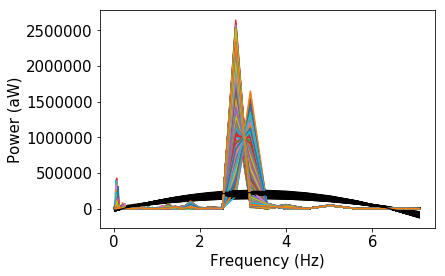

C:\Users\a6q\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\ticker.py:2039: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


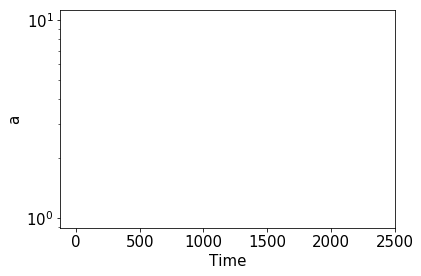

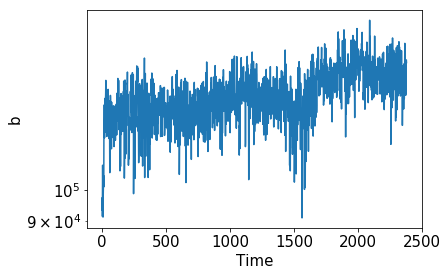

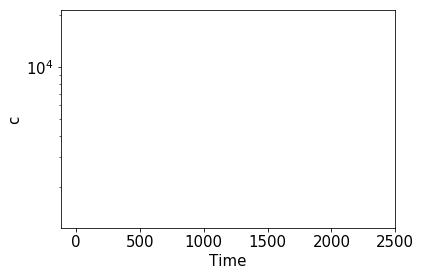

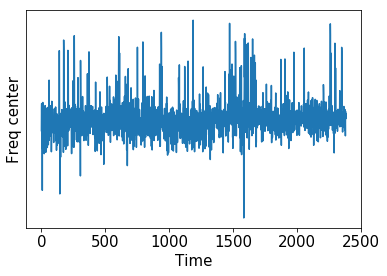

In [5]:
#fit power vs. freq spectra to find frequencies at which minimum power occurs

def quadratic(f, a, b, c):  # define variables in each function
    return a*f**2 + b*f + c

alist = []; blist = []; clist = [] #save lists of fitting parameters
    
for i in range(len(fmat)): #loop over number of timing cycles
    try:
        popt, pcov = curve_fit(quadratic, fmat[i], pmat[i]) #find fit parameters
        fit =  quadratic(fmat[i], *popt) #build fit line
        alist.append(popt[0]); blist.append(popt[1]); clist.append(popt[2]) #get fitting parameters from popt
    
        plt.plot(fmat[i],pmat[i])#, s=.5) #plot fits
        plt.plot(fmat[i],fit,linewidth=1, c='k')
        
    except RuntimeError: #if error in fitting, keep going amnd assign 0 values
        alist.append(0); blist.append(0); clist.append(0)
        print('error in fitting column index ' + format(i))

plt.xlabel('Frequency (Hz)',fontsize=15); plt.ylabel('Power (aW)',fontsize=15);plt.show()

plt.semilogy(timecycle,alist)
plt.xlabel('Time',fontsize=15); plt.ylabel('a' ,fontsize=15); plt.show()

plt.semilogy(timecycle,blist)
plt.xlabel('Time',fontsize=15); plt.ylabel('b',fontsize=15); plt.show()

plt.semilogy(timecycle,clist)
plt.xlabel('Time',fontsize=15); plt.ylabel('c',fontsize=15); plt.show()

xapex = np.divide(np.negative(blist), np.multiply(alist,2)) #x-value of quadratic apex
plt.semilogy(timecycle, xapex)
plt.xlabel('Time',fontsize=15); plt.ylabel('Freq center',fontsize=15); plt.show()


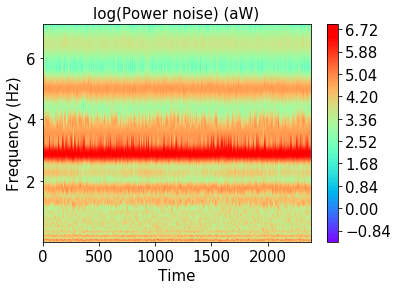

In [6]:
#plot in frequency domain over time
tmatflat = np.array([]) #make flat array of repeating "times"
for i in range(len(fmat)): tmatflat = np.append(tmatflat, np.ones(len(fmat[0]))*i)

fmatflat = fmat.flatten(); imatflat = imat.flatten()
vmatflat = vmat.flatten(); pmatflat = pmat.flatten(); zmatflat = zmat.flatten()

# plot heatmaps of time/frequency-dependent noise
# set X, Y, and Z for plot
X, Y, Z, = tmatflat, fmatflat, np.log10(pmatflat) #time, frequency, noise

# create x-y points to be used in heatmap
xi = np.linspace(X.min(),X.max(),1000)
yi = np.linspace(Y.min(),Y.max(),1000)
# Z is a matrix of x-y values
zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')

# Create the contour plot
CS = plt.contourf(xi, yi, zi, 150, cmap=plt.cm.rainbow, vmax=np.amax(Z), vmin=np.amin(Z))
plt.colorbar(); plt.xlabel('Time',fontsize=15); plt.ylabel('Frequency (Hz)',fontsize=15);
plt.title('log(Power noise) (aW)',fontsize=15); plt.show()

In [7]:
len(alist)

2382

In [6]:
# IMPORT TIME-DOMAIN DATA ##########################################################################################
tfile = 'C:\\Users\\a6q\\Desktop\\SU8-ZnO\\CorrEL noise measurements\\m-swcnt time copy.txt' #frequency filename
rawtdata = pd.read_csv(ffile, skiprows=4307, header=0, error_bad_lines=False, sep='\s+') #read in file
####################################################################################################################
tfloatdata = rawtdata.apply(pd.to_numeric, errors='coerce') #change from string to float, coercing to NaN 
print(tfloatdata)

        volt.noise/V  curr.noise/A
0          -0.008240     -0.000948
1          -0.008240     -0.000947
2          -0.008301     -0.000949
3          -0.008255     -0.000947
4          -0.008255     -0.000947
5          -0.008209     -0.000945
6          -0.008255     -0.000947
7          -0.008255     -0.000947
8          -0.008301     -0.000949
9          -0.008255     -0.000947
10         -0.008255     -0.000947
11         -0.008255     -0.000947
12         -0.008194     -0.000945
13         -0.008255     -0.000948
14         -0.008255     -0.000947
15         -0.008301     -0.000949
16         -0.008255     -0.000947
17         -0.008255     -0.000947
18         -0.008255     -0.000947
19         -0.008209     -0.000945
20         -0.008255     -0.000947
21         -0.008255     -0.000947
22         -0.008301     -0.000949
23         -0.008255     -0.000947
24         -0.008270     -0.000947
25         -0.008224     -0.000944
26         -0.008255     -0.000946
27         -0.008255

852 points removed


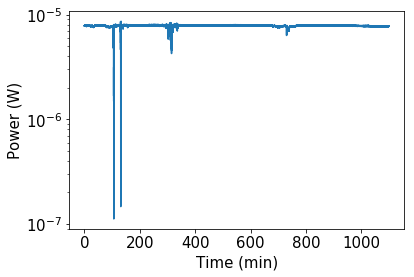

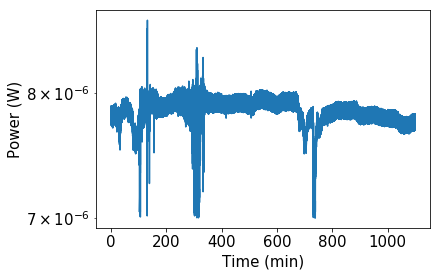

In [42]:
#ORGANIZE TIME-DOMAIN DATA

tv0 = np.array(tfloatdata['volt.noise/V']) #create voltage nad current arrays for time-domain data 
ti0 = np.array(tfloatdata['curr.noise/A'])
tp0 = np.multiply(tv0,ti0) #calculate power noise
tt0 = (np.arange(len(tv0))*0.488)/60 #create time array in minutes

tv = np.array([]); ti = np.array([]) #name new arrays for those with high-noise points deleted
tt = np.array([]); tp = np.array([])

for i in range(len(tt0)): #remove points that are extremely far away from average
    if tp0[i] > 7e-6:
        tv = np.append(tv, tv0[i]); ti = np.append(ti, ti0[i])
        tt = np.append(tt, tt0[i]); tp = np.append(tp, tp0[i])
    else: pass
        
print(format(len(tt0) - len(tt)) + ' points removed')   
    
plt.semilogy(tt0, tp0)
plt.xlabel('Time (min)', fontsize=15); plt.ylabel('Power (W)', fontsize=15)
plt.show()

plt.semilogy(tt, tp)
plt.xlabel('Time (min)', fontsize=15); plt.ylabel('Power (W)', fontsize=15)
plt.show()

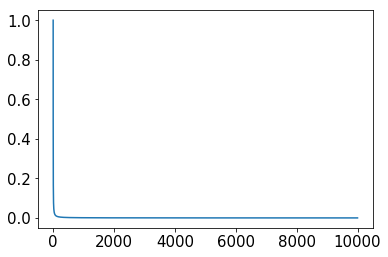

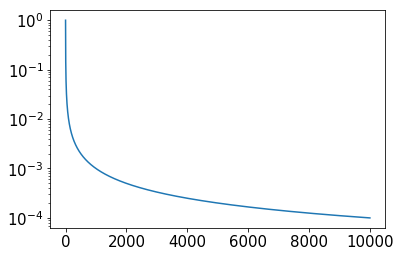

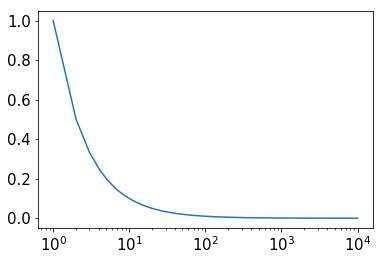

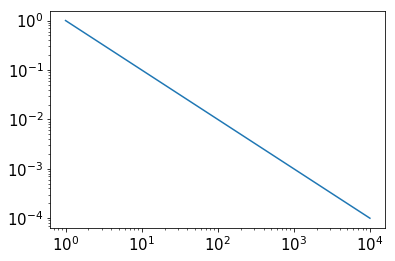

In [917]:
xx = np.arange(10000)+1
yy = 1/xx
plt.plot(xx,yy); plt.show()
plt.semilogy(xx,yy); plt.show()
plt.semilogx(xx,yy); plt.show()
plt.loglog(xx,yy); plt.show()